## **Hepatitis B, Hepatitis C, Cirrhosis, Liver Cancer 예측 model 생성하기**
### (KNHANES 8기(2019-2022) Data를 활용하여)

### **Library Settings**

In [3]:
# load modules
# basic
import numpy as np
import pandas as pd
from tqdm import tqdm
import itertools

## graph
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots

## sklearn
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.compose import ColumnTransformer, make_column_transformer
from sklearn.impute import SimpleImputer, KNNImputer
from sklearn.pipeline import Pipeline
from sklearn.decomposition import PCA

## statistics
from scipy.stats import pearsonr
from scipy import stats
import statsmodels.api as sm
from statsmodels.stats.multicomp import pairwise_tukeyhsd
from scipy.stats import bartlett
from scipy.stats import levene

import matplotlib.animation as animation
from matplotlib.gridspec import GridSpec #data viz
from matplotlib.animation import FuncAnimation #animation
import os 

In [25]:
file_path = 'C:/Users/user/OneDrive/Upstage AI BootCamp/Machine Learning/프로젝트/Liver_Data/KNHANES/data/KNHANES_8.csv'
KNHANES_org = pd.read_csv(file_path, encoding='latin1')

C:\Users\user\AppData\Local\Temp\ipykernel_13140\860478219.py:2: DtypeWarning: Columns (111,141,209,218,225,251,279,312,333,349,403,422,460,526,536,548,568,621,638,711,713,715,826,827,896,912,914,930,959) have mixed types. Specify dtype option on import or set low_memory=False.
  KNHANES_org = pd.read_csv(file_path, encoding='latin1')


### **데이터 이해 및 초기 탐색**

In [26]:
KNHANES_org

,mod_d,ID,ID_fam,year,region,town_t,apt_t,psu,sex,age,...,T_VHIT_EX_L,T_VHIT_EX_L_1,T_VHIT_GA_R,T_VHIT_GA_L,T_VHIT_COR_R,T_VHIT_COR_L,T_SOds,E_RT,E_CT,E_CLC_T
0,2023.07.11.,A751215301,A7512153,2019,1,1,1,A751,1,61,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2023.07.11.,A751215303,A7512153,2019,1,1,1,A751,1,28,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2023.07.11.,A751220401,A7512204,2019,1,1,1,A751,1,53,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2023.07.11.,A751220402,A7512204,2019,1,1,1,A751,2,50,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2023.07.11.,A751220403,A7512204,2019,1,1,1,A751,1,16,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
22554,2023.07.11.,R904351302,R9043513,2021,8,2,2,R904,1,25,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,4.0,888.0
22555,2023.07.11.,R904353001,R9043530,2021,8,2,2,R904,1,45,...,1.0,NaN,1.33,1.12,0.0,0.0,0.0,1.0,4.0,888.0
22556,2023.07.11.,R904353002,R9043530,2021,8,2,2,R904,2,43,...,1.0,NaN,1.03,1.03,0.0,0.0,0.0,1.0,3.0,888.0
22557,2023.07.11.,R904353003,R9043530,2021,8,2,2,R904,1,8,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


- 총 22,559개의 행과 960개의 열

#### 필요한 변수 추출하여 KNHANES_LIVER 생성

In [30]:
# 필요한 변수 목록
selected_columns_full = [
    "ID",	"ID_fam",	"year",	"region",	"sex",	"age",	"age_month",	"incm",	"ho_incm",	"incm5",	"ho_incm5",	"edu",	"occp",	"cfam",	"genertn",	"allownc",	"house",	
    "live_t",	"ainc_unit1",	"ainc_1",	"ainc",	"D_1_1",	"DI1_dg",	"DI1_ag",	"DI1_pr",	"DI1_pt",	"DI1_2",	"DI2_dg",	"DI2_ag",	"DI2_pr",	"DI2_pt",	"DI2_2",	
    "DI3_dg",	"DI3_ag",	"DI3_pr",	"DI3_pt",	"DI3_2",	"DI4_dg",	"DI4_pr",	"DI4_pt",	"DI5_dg",	"DI5_ag",	"DI5_pr",	"DI5_pt",	"DE2_dg",	"DE2_ag",	"DE2_pr",	
    "DE2_pt",	"DE1_dg",	"DE1_ag",	"DE1_pr",	"DE1_pt",	"DE1_3",	"DE1_31",	"DE1_32",	"DE1_33",	"DE1_34",	"DE1_35",	"DC2_dg",	"DC2_ag",	"DC2_pr",	"DC2_pt",	
    "DC7_dg",	"DC7_ag",	"DC7_pr",	"DC7_pt",	"DC11_tp",	"DC11_dg",	"DC11_ag",	"DC11_pr",	"DC11_pt",	"DF2_dg",	"DF2_ag",	"DF2_pr",	"DF2_pt",	"DN1_dg",	"DN1_ag",	
    "DN1_pr",	"DN1_pt",	"DK8_dg",	"DK8_ag",	"DK8_pr",	"DK8_pt",	"DK9_dg",	"DK9_ag",	"DK9_pr",	"DK9_pt",	"DK4_dg",	"DK4_ag",	"DK4_pr",	"DK4_pt",	"LQ4_00",	
    "LQ4_04",	"LQ4_06",	"LQ4_07",	"LQ4_10",	"LQ4_15",	"LQ4_21",	"LQ_5EQL",	"LQ_5HT",	"LQ_7HT",	"educ",	"CH2_1",	"EC_occp",	"BO1",	"BO1_1",	"BO1_2",	"BO1_3",	
    "BO2_1",	"BO3_01",	"BO3_02",	"BO3_03",	"BO3_14",	"BO3_05",	"BO3_04",	"BO3_12",	"BO3_07",	"BO3_09",	"BO3_10",	"BO3_11",	"BD1",	"BD2",	"BD1_11",	"BD2_1",	
    "BD2_14",	"BD2_31",	"BD2_32",	"BD7_4",	"BD7_5",	"BD9_1",	"BD9_2",	"dr_month",	"BP1",	"BP5",	"BP6_10",	"BP6_2",	"BP6_31",	"BP7",	"mh_stress",	"BS1_1",	
    "BS2_1",	"BS3_1",	"BS3_2",	"BS3_3",	"BS6_2",	"BS6_2_1",	"BS6_2_2",	"BS6_3",	"BS6_4",	"BS6_4_1",	"BS6_4_2",	"BS12_37",	"BS12_47",	"BS12_47_1",	"BS12_47_2",	
    "BS12_1",	"BS12_2",	"BS12_31",	"BS12_32",	"BS12_33",	"BS12_34",	"BS12_35",	"BS12_36",	"BS12_41",	"BS12_42",	"BS12_43",	"BS12_44",	"BS12_45",	"BS12_46",	"BS5_4",	
    "BS5",	"BS5_1",	"BS5_21",	"BS5_28",	"BS5_26",	"BS5_33",	"BS5_34",	"BS5_32",	"BS5_29",	"BS5_30",	"BS5_31",	"BS8_2",	"BS9_2",	"BS13",	"BS10_1",	"BS2",	
    "BS10_2",	"BS10_3",	"sm_presnt",	"BE3_71",	"BE3_72",	"BE3_73",	"BE3_74",	"BE3_81",	"BE3_82",	"BE3_83",	"BE3_84",	"BE3_91",	"BE3_92",	"BE3_93",	"BE3_94",	
    "BE3_75",	"BE3_76",	"BE3_77",	"BE3_78",	"BE3_85",	"BE3_86",	"BE3_87",	"BE3_88",	"BE8_1",	"BE8_2",	"BE3_31",	"BE3_32",	"BE3_33",	"BE5_1",	"BE9",	
    "pa_aerobic",	"HE_fst",	"HE_HPdr",	"HE_DMdr",	"HE_prg",	"HE_dprg",	"HE_fh",	"HE_HPfh1",	"HE_HPfh2",	"HE_HPfh3",	"HE_HLfh1",	"HE_HLfh2",	"HE_HLfh3",	"HE_IHDfh1",	
    "HE_IHDfh2",	"HE_IHDfh3",	"HE_STRfh1",	"HE_STRfh2",	"HE_STRfh3",	"HE_DMfh1",	"HE_DMfh2",	"HE_DMfh3",	"HE_THfh1",	"HE_THfh2",	"HE_THfh3",	"HE_HBfh1",	"HE_HBfh2",	
    "HE_HBfh3",	"HE_rPLS",	"HE_PLS_15",	"HE_mPLS",	"HE_nARM",	"HE_sbp1",	"HE_dbp1",	"HE_sbp2",	"HE_dbp2",	"HE_sbp3",	"HE_dbp3",	"HE_sbp",	"HE_dbp",	"HE_HP",	"HE_ht",	
    "HE_wt",	"HE_BMI",	"HE_obe",	"HE_glu",	"HE_HbA1c",	"HE_insulin",	"HE_insulin_etc",	"HE_DM_HbA1c",	"HE_chol",	"HE_HDL_st2",	"HE_TG",	"HE_LDL_drct",	"HE_HCHOL",	
    "HE_HTG",	"HE_ast",	"HE_alt",	"HE_alt_etc",	"HE_hepaB",	"HE_hepaC",	"HE_HB",	"HE_HCT",	"HE_anem",	"HE_BUN",	"HE_crea",	"HE_WBC",	"HE_RBC",	"HE_Bplt",	"HE_Uacid",	
    "HE_Uacid_etc",	"HE_Ubil",	"HE_Ucrea",	"HE_Ualb",	"GS_use",	"T_Q_SINU_1",	"E_RT",	"E_CT",	"L_BR_FQ",	"L_LN_FQ",	"L_DN_FQ",	"DQ_CWATER",	"DA_CWATER",	"DQ_SODA",	
    "DA_SODA",	"DQ_COFFEE",	"DA_COFFEE",	"DQ_SCOFFEE",	"DA_SCOFFEE",	"DQ_TEA",	"DA_TEA",	"DQ_STEA",	"DA_STEA",	"Y_MTM_YN",	"Y_MTM_S1",	"Y_MTM_S2",	"Y_MTM_D1",	"Y_MTM_D2",	
    "DC12_tp",	"DC12_dg",	"DC12_ag",	"DC12_pr",	"DC12_pt",	"BP_PHQ_1",	"BP_PHQ_2",	"BP_PHQ_3",	"BP_PHQ_4",	"BP_PHQ_5",	"BP_PHQ_6",	"BP_PHQ_7",	"BP_PHQ_8",	"BP_PHQ_9",	"mh_PHQ_S",	
    "BP16_11",	"BP16_12",	"BP16_13",	"BP16_14",	"BP16_21",	"BP16_22",	"BP16_23",	"BP16_24"
]

# 필요한 변수들만 추출하여 새로운 데이터 프레임 생성
KNHANES_Liver = KNHANES_org[selected_columns_full]

# 생성된 데이터 프레임의 정보 확인
KNHANES_Liver.info(), KNHANES_Liver.head()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 22559 entries, 0 to 22558
Columns: 337 entries, ID to BP16_24
dtypes: float64(315), int64(11), object(11)
memory usage: 58.0+ MB


(None,
            ID    ID_fam  year  region  sex  age  age_month  incm  ho_incm  \
 0  A751215301  A7512153  2019       1    1   61        NaN   1.0      2.0   
 1  A751215303  A7512153  2019       1    1   28        NaN   1.0      2.0   
 2  A751220401  A7512204  2019       1    1   53        NaN   1.0      1.0   
 3  A751220402  A7512204  2019       1    2   50        NaN   1.0      1.0   
 4  A751220403  A7512204  2019       1    1   16        NaN   1.0      1.0   
 
    incm5  ...  BP_PHQ_9  mh_PHQ_S  BP16_11  BP16_12  BP16_13  BP16_14  \
 0    1.0  ...       NaN       NaN      NaN      NaN      NaN      NaN   
 1    1.0  ...       NaN       NaN      NaN      NaN      NaN      NaN   
 2    1.0  ...       NaN       NaN      NaN      NaN      NaN      NaN   
 3    1.0  ...       NaN       NaN      NaN      NaN      NaN      NaN   
 4    1.0  ...       NaN       NaN      NaN      NaN      NaN      NaN   
 
    BP16_21  BP16_22  BP16_23  BP16_24  
 0      NaN      NaN      NaN      N

- 총 22,559개의 행과 337개의 열

#### 혈청학적 검사 및 질병 관련 변수만 추출하여 KNHANES_dis 생성하기

In [39]:
selected_columns_dis = [
    "ID",   "ID_fam",	"year", "region",	"sex",	"age",	"age_month",	"DI1_pr",   "DI1_pt",	"DI2_pr",   "DI2_pt",  "DI3_pr",    "DI3_pt",   "DI4_pr",   "DI4_pt",   "DI5_pr",
    "DI5_pt",   "DE2_pr",	"DE2_pt",   "DE1_pr",   "DE1_pt",	"DC2_dg",   "DC2_ag",   "DC2_pr",   "DC2_pt",  "DC7_pr",	"DC7_pt",	"DC11_tp",	"DC11_pr",	"DC11_pt",  "DF2_pr",	"DF2_pt",   "DN1_pr",
    "DK8_dg",   "DK8_ag",   "DK8_pr",   "DK8_pt",   "DK9_dg",   "DK9_ag",   "DK9_pr",   "DK9_pt",   "DK4_dg",   "DK4_ag",   "DK4_pr",	"DK4_pt",   "HE_HBfh1", "HE_HBfh2", "HE_HBfh3",
    "HE_glu",	"HE_HbA1c",	"HE_insulin",	"HE_DM_HbA1c",	"HE_chol",	"HE_HDL_st2",   "HE_TG",	"HE_LDL_drct",	"HE_HCHOL", "HE_HTG",	"HE_ast",	"HE_alt",	"HE_hepaB",
    "HE_hepaC",	"HE_HB",	"HE_HCT",	"HE_anem",	"HE_BUN",	"HE_crea",	"HE_WBC",   "HE_RBC",   "HE_Bplt",	"HE_Uacid",	"HE_Ubil",	"HE_Ucrea",	"HE_Ualb",	"Y_MTM_YN",	"Y_MTM_S1",
    "Y_MTM_S2", "Y_MTM_D1",	"Y_MTM_D2",	"DC12_tp",  "DC12_pr",	"DC12_pt"
]

# serologic 변수들만 추출하여 새로운 데이터 프레임 생성
KNHANES_dis = KNHANES_org[selected_columns_dis]

# 생성된 데이터 프레임의 정보 확인
KNHANES_dis.info(), KNHANES_dis.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 22559 entries, 0 to 22558
Data columns (total 82 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   ID           22559 non-null  object 
 1   ID_fam       22559 non-null  object 
 2   year         22559 non-null  int64  
 3   region       22559 non-null  int64  
 4   sex          22559 non-null  int64  
 5   age          22559 non-null  int64  
 6   age_month    1168 non-null   float64
 7   DI1_pr       21530 non-null  float64
 8   DI1_pt       21530 non-null  float64
 9   DI2_pr       21530 non-null  float64
 10  DI2_pt       21530 non-null  float64
 11  DI3_pr       21530 non-null  float64
 12  DI3_pt       21530 non-null  float64
 13  DI4_pr       20336 non-null  float64
 14  DI4_pt       20336 non-null  float64
 15  DI5_pr       21530 non-null  float64
 16  DI5_pt       21530 non-null  float64
 17  DE2_pr       21530 non-null  float64
 18  DE2_pt       21530 non-null  float64
 19  DE1_

(None,
            ID    ID_fam  year  region  sex  age  age_month  DI1_pr  DI1_pt  \
 0  A751215301  A7512153  2019       1    1   61        NaN     1.0     1.0   
 1  A751215303  A7512153  2019       1    1   28        NaN     8.0     8.0   
 2  A751220401  A7512204  2019       1    1   53        NaN     8.0     8.0   
 3  A751220402  A7512204  2019       1    2   50        NaN     8.0     8.0   
 4  A751220403  A7512204  2019       1    1   16        NaN     NaN     NaN   
 
    DI2_pr  ...  HE_Ucrea  HE_Ualb  Y_MTM_YN  Y_MTM_S1  Y_MTM_S2  Y_MTM_D1  \
 0     8.0  ...      92.0      8.9       NaN       NaN       NaN       NaN   
 1     8.0  ...     165.1      6.4       NaN       NaN       NaN       NaN   
 2     8.0  ...     108.7      4.3       NaN       NaN       NaN       NaN   
 3     8.0  ...      91.7      7.5       NaN       NaN       NaN       NaN   
 4     NaN  ...       NaN      NaN       NaN       NaN       NaN       NaN   
 
    Y_MTM_D2  DC12_tp  DC12_pr  DC12_pt  
 0   

- 총 22,559개의 행과 82개의 열

In [40]:

# Pandas 설정을 변경하여 모든 결측치가 있는 변수의 합계를 출력할 수 있도록 설정
pd.set_option('display.max_rows', None)

# 결측치가 있는 모든 변수의 합계 출력
missing_values_dis = KNHANES_dis.isnull().sum()
missing_values_dis_only = missing_values_dis[missing_values_dis > 0]
print(missing_values_dis_only)


age_month      21391
DI1_pr          1029
DI1_pt          1029
DI2_pr          1029
DI2_pt          1029
DI3_pr          1029
DI3_pt          1029
DI4_pr          2223
DI4_pt          2223
DI5_pr          1029
DI5_pt          1029
DE2_pr          1029
DE2_pt          1029
DE1_pr          1029
DE1_pt          1029
DC2_dg          1029
DC2_ag          1029
DC2_pr          1029
DC2_pt          1029
DC7_pr          1029
DC7_pt          1029
DC11_tp        22298
DC11_pr         1029
DC11_pt         1029
DF2_pr          1029
DF2_pt          1029
DN1_pr          1029
DK8_dg          1029
DK8_ag          1029
DK8_pr          1029
DK8_pt          1029
DK9_dg          1029
DK9_ag          1029
DK9_pr          1029
DK9_pt          1029
DK4_dg          1029
DK4_ag          1029
DK4_pr          1029
DK4_pt          1029
HE_HBfh1        2975
HE_HBfh2        2975
HE_HBfh3        2975
HE_glu          3441
HE_HbA1c        3453
HE_insulin      3447
HE_DM_HbA1c     5686
HE_chol         3441
HE_HDL_st2   

#### 혈청학적 검사 및 B형 간염 변수만 추출하여 KNHANES_sero 생성하기

In [45]:
selected_columns_sero = [
    "ID",   "ID_fam",	"year", "region",	"sex",	"age",	"age_month",	"DC2_dg",   "DC2_ag",   "DC2_pr",   "DC2_pt",   "DK8_dg",   "DK8_ag",   "DK8_pr",   "DK8_pt",   "DK9_dg",
    "DK9_ag",   "DK9_pr",   "DK9_pt",   "DK4_dg",   "DK4_ag",   "DK4_pr",	"DK4_pt",   "HE_glu",	"HE_HbA1c",	"HE_insulin",	"HE_chol",  "HE_HDL_st2",   "HE_TG",    "HE_LDL_drct",
    "HE_ast",	"HE_alt",	"HE_hepaB", "HE_hepaC",	"HE_HB",	"HE_BUN",	"HE_crea",	"HE_WBC",   "HE_RBC",   "HE_Bplt",	"HE_Uacid",	"HE_Ubil",	"HE_Ucrea",	"HE_Ualb"
]

# serologic 변수들만 추출하여 새로운 데이터 프레임 생성
KNHANES_sero = KNHANES_org[selected_columns_sero]

# 생성된 데이터 프레임의 정보 확인
KNHANES_sero.info(), KNHANES_sero.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 22559 entries, 0 to 22558
Data columns (total 44 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   ID           22559 non-null  object 
 1   ID_fam       22559 non-null  object 
 2   year         22559 non-null  int64  
 3   region       22559 non-null  int64  
 4   sex          22559 non-null  int64  
 5   age          22559 non-null  int64  
 6   age_month    1168 non-null   float64
 7   DC2_dg       21530 non-null  float64
 8   DC2_ag       21530 non-null  float64
 9   DC2_pr       21530 non-null  float64
 10  DC2_pt       21530 non-null  float64
 11  DK8_dg       21530 non-null  float64
 12  DK8_ag       21530 non-null  float64
 13  DK8_pr       21530 non-null  float64
 14  DK8_pt       21530 non-null  float64
 15  DK9_dg       21530 non-null  float64
 16  DK9_ag       21530 non-null  float64
 17  DK9_pr       21530 non-null  float64
 18  DK9_pt       21530 non-null  float64
 19  DK4_

(None,
            ID    ID_fam  year  region  sex  age  age_month  DC2_dg  DC2_ag  \
 0  A751215301  A7512153  2019       1    1   61        NaN     0.0   888.0   
 1  A751215303  A7512153  2019       1    1   28        NaN     0.0   888.0   
 2  A751220401  A7512204  2019       1    1   53        NaN     0.0   888.0   
 3  A751220402  A7512204  2019       1    2   50        NaN     0.0   888.0   
 4  A751220403  A7512204  2019       1    1   16        NaN     NaN     NaN   
 
    DC2_pr  ...  HE_HB  HE_BUN  HE_crea  HE_WBC  HE_RBC  HE_Bplt  HE_Uacid  \
 0     8.0  ...   16.0    15.0     1.09    6.00    4.85    283.0       8.8   
 1     8.0  ...   14.4    16.0     0.98    4.39    4.55    371.0       5.4   
 2     8.0  ...   15.5    13.0     0.92    5.43    5.10    222.0       5.9   
 3     8.0  ...   12.2    14.0     0.77    6.88    3.95    405.0       4.7   
 4     NaN  ...    NaN     NaN      NaN     NaN     NaN      NaN       NaN   
 
    HE_Ubil  HE_Ucrea  HE_Ualb  
 0      0.0   

- 총 22,559개의 행과 44개의 열

In [46]:
KNHANES_sero.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 22559 entries, 0 to 22558
Data columns (total 44 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   ID           22559 non-null  object 
 1   ID_fam       22559 non-null  object 
 2   year         22559 non-null  int64  
 3   region       22559 non-null  int64  
 4   sex          22559 non-null  int64  
 5   age          22559 non-null  int64  
 6   age_month    1168 non-null   float64
 7   DC2_dg       21530 non-null  float64
 8   DC2_ag       21530 non-null  float64
 9   DC2_pr       21530 non-null  float64
 10  DC2_pt       21530 non-null  float64
 11  DK8_dg       21530 non-null  float64
 12  DK8_ag       21530 non-null  float64
 13  DK8_pr       21530 non-null  float64
 14  DK8_pt       21530 non-null  float64
 15  DK9_dg       21530 non-null  float64
 16  DK9_ag       21530 non-null  float64
 17  DK9_pr       21530 non-null  float64
 18  DK9_pt       21530 non-null  float64
 19  DK4_

In [47]:
# Pandas 설정을 변경하여 모든 결측치가 있는 변수의 합계를 출력할 수 있도록 설정
pd.set_option('display.max_rows', None)

# 결측치가 있는 모든 변수의 합계 출력
missing_values_sero = KNHANES_sero.isnull().sum()
missing_values_sero_only = missing_values_sero[missing_values_sero > 0]
print(missing_values_sero_only)

age_month      21391
DC2_dg          1029
DC2_ag          1029
DC2_pr          1029
DC2_pt          1029
DK8_dg          1029
DK8_ag          1029
DK8_pr          1029
DK8_pt          1029
DK9_dg          1029
DK9_ag          1029
DK9_pr          1029
DK9_pt          1029
DK4_dg          1029
DK4_ag          1029
DK4_pr          1029
DK4_pt          1029
HE_glu          3441
HE_HbA1c        3453
HE_insulin      3447
HE_chol         3441
HE_HDL_st2      3441
HE_TG           3441
HE_LDL_drct    20135
HE_ast          3441
HE_alt          3446
HE_hepaB        3441
HE_hepaC        3441
HE_HB           3452
HE_BUN          3441
HE_crea         3441
HE_WBC          3452
HE_RBC          3452
HE_Bplt         3489
HE_Uacid        3454
HE_Ubil         3578
HE_Ucrea        2634
HE_Ualb         3941
dtype: int64


In [49]:
# 결측치 합계를 텍스트 파일로 저장
missing_values_sero_only.to_csv('../data/KNHANES_sero_missing_values.csv', index=True)

In [50]:
KNHANES_sero.describe()

,year,region,sex,age,age_month,DC2_dg,DC2_ag,DC2_pr,DC2_pt,DK8_dg,...,HE_HB,HE_BUN,HE_crea,HE_WBC,HE_RBC,HE_Bplt,HE_Uacid,HE_Ubil,HE_Ucrea,HE_Ualb
count,22559.000000,22559.000000,22559.000000,22559.000000,1168.000000,21530.000000,21530.000000,21530.000000,21530.000000,21530.000000,...,19107.000000,19118.000000,19118.000000,19107.000000,19107.000000,19070.000000,19105.000000,18981.000000,19925.000000,18618.000000
mean,2019.954785,7.692540,1.541026,45.088878,50.196918,1.851324,893.415002,8.048862,8.048676,1.862657,...,13.878406,15.016320,0.794674,6.186708,4.561085,258.296277,5.182565,0.000527,138.777265,25.023096
std,0.819618,5.010794,0.498325,22.618500,20.460020,3.446512,35.909398,0.322028,0.326354,3.444961,...,1.553524,4.925712,0.249068,1.717663,0.498259,63.573398,1.399814,0.038405,80.538381,116.084237
min,2019.000000,1.000000,1.000000,1.000000,12.000000,0.000000,54.000000,0.000000,0.000000,0.000000,...,5.500000,4.000000,0.200000,1.690000,2.070000,14.000000,1.300000,0.000000,2.900000,1.000000
25%,2019.000000,3.000000,1.000000,27.000000,34.000000,0.000000,888.000000,8.000000,8.000000,0.000000,...,12.900000,12.000000,0.650000,4.990000,4.210000,216.000000,4.200000,0.000000,78.500000,4.900000
50%,2020.000000,9.000000,2.000000,48.000000,51.000000,0.000000,888.000000,8.000000,8.000000,0.000000,...,13.800000,14.000000,0.760000,5.950000,4.540000,255.000000,5.000000,0.000000,122.700000,8.200000
75%,2021.000000,11.000000,2.000000,64.000000,67.250000,0.000000,888.000000,8.000000,8.000000,0.000000,...,15.000000,17.000000,0.910000,7.080000,4.900000,296.000000,6.100000,0.000000,182.900000,14.300000
max,2021.000000,17.000000,2.000000,80.000000,83.000000,9.000000,999.000000,9.000000,9.000000,9.000000,...,20.400000,95.000000,8.350000,27.290000,7.070000,900.000000,13.100000,4.000000,622.800000,3629.700000


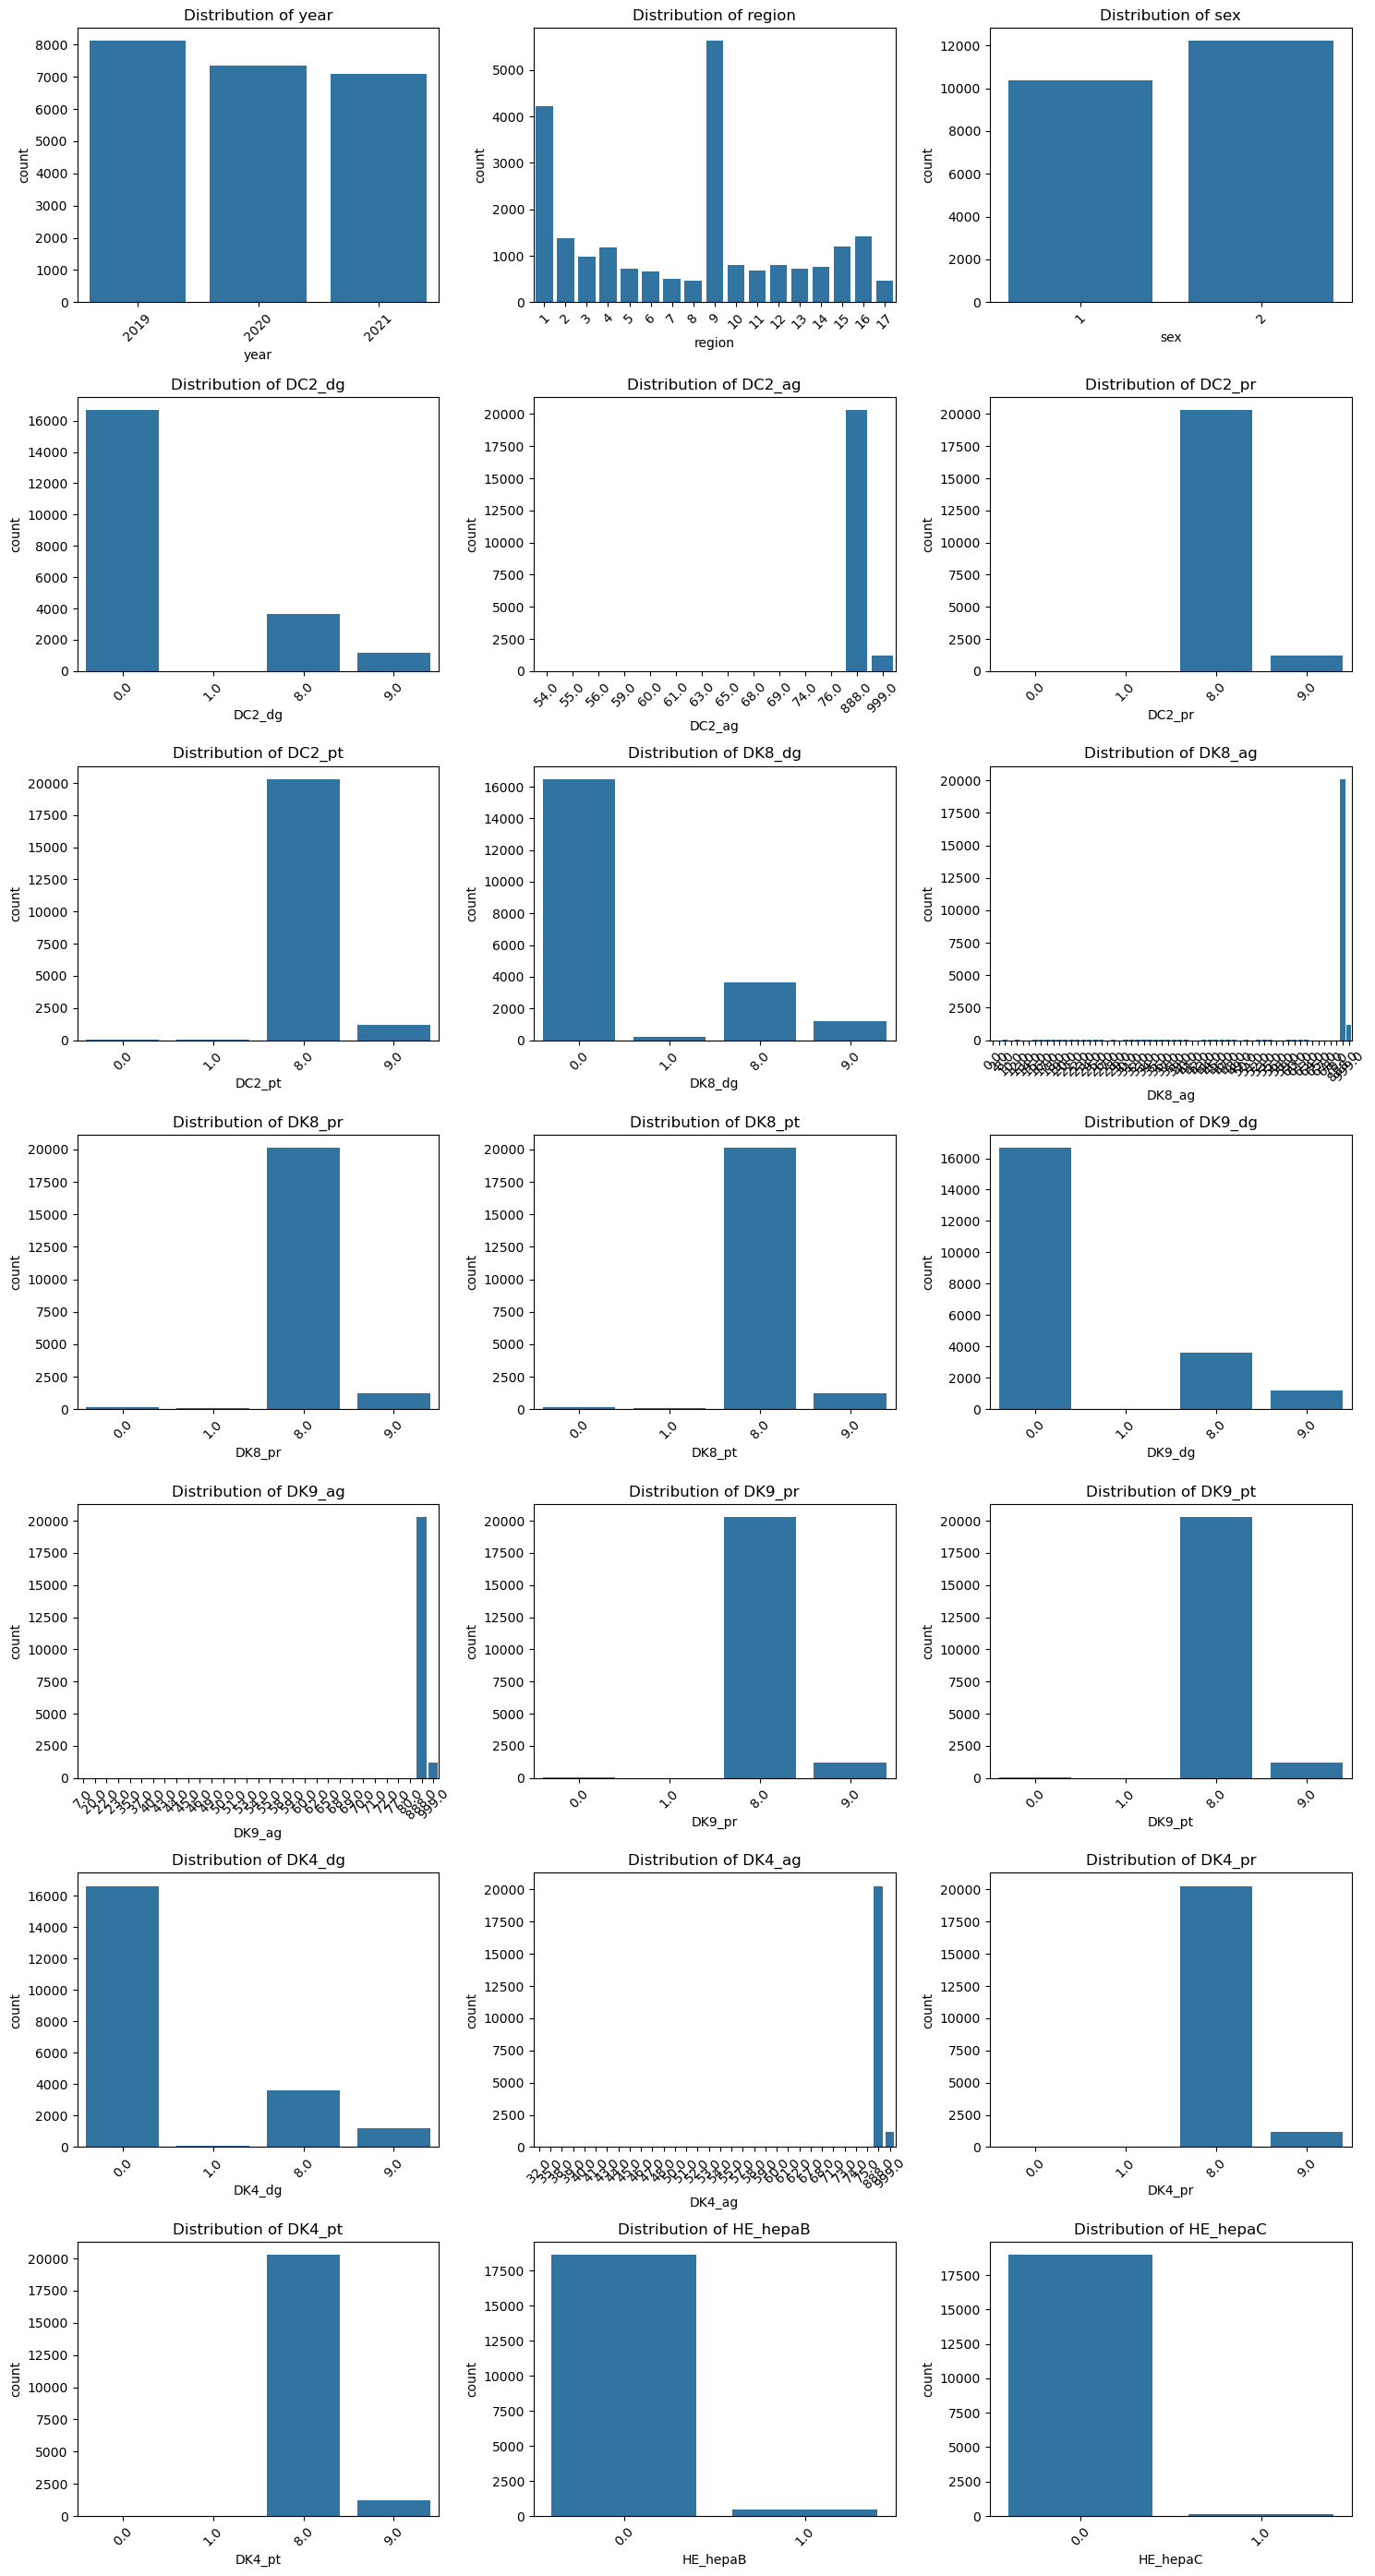

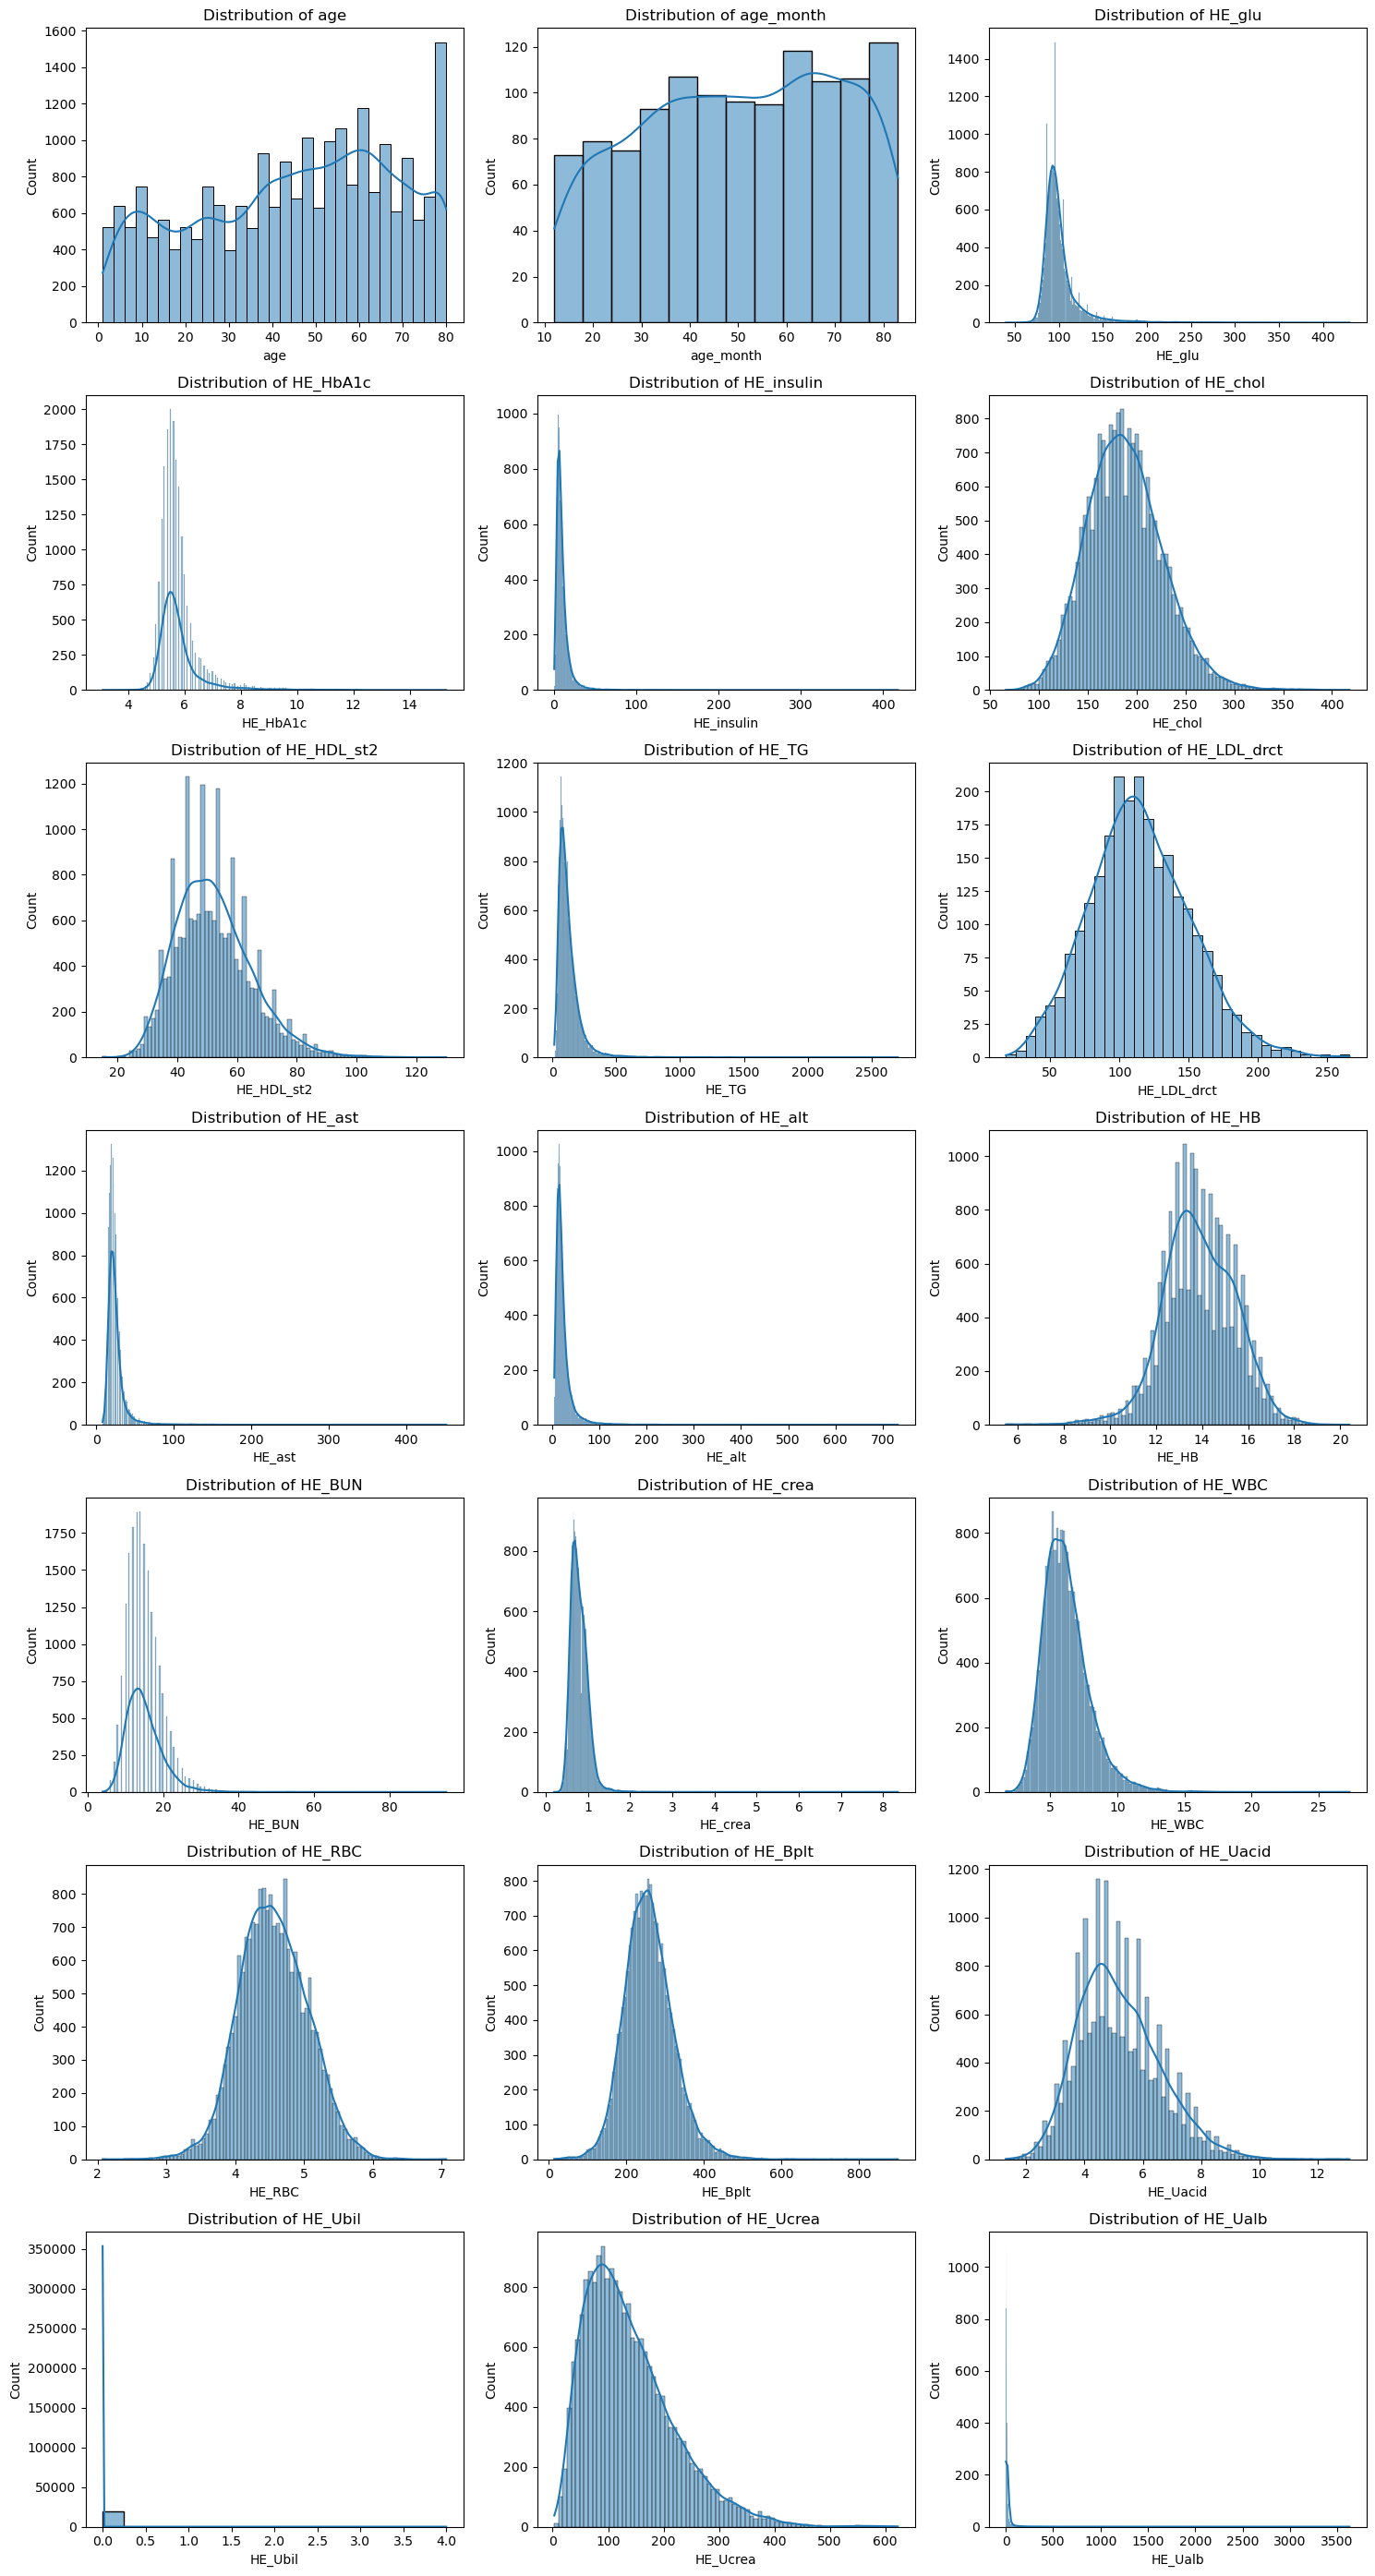

In [52]:

# 범주형 변수 목록
categorical_vars = ["year", "region", "sex", "DC2_dg", "DC2_ag", "DC2_pr", "DC2_pt", "DK8_dg", "DK8_ag", "DK8_pr", "DK8_pt", 
                    "DK9_dg", "DK9_ag", "DK9_pr", "DK9_pt", "DK4_dg", "DK4_ag", "DK4_pr", "DK4_pt", "HE_hepaB", "HE_hepaC"]

# 수치형 변수 목록
numeric_vars = ["age", "age_month", "HE_glu", "HE_HbA1c", "HE_insulin", "HE_chol", "HE_HDL_st2", "HE_TG", "HE_LDL_drct", 
                "HE_ast", "HE_alt", "HE_HB", "HE_BUN", "HE_crea", "HE_WBC", "HE_RBC", "HE_Bplt", "HE_Uacid", "HE_Ubil", "HE_Ucrea", "HE_Ualb"]

# 범주형 변수 시각화
num_rows_cat = len(categorical_vars) // 3 + (len(categorical_vars) % 3 > 0)
plt.figure(figsize=(15, 4 * num_rows_cat))

for i, col in enumerate(categorical_vars, 1):
    plt.subplot(num_rows_cat, 3, i)
    sns.countplot(x=KNHANES_sero[col].astype('category'))
    plt.title(f'Distribution of {col}')
    plt.xticks(rotation=45)

plt.tight_layout()
plt.show()

# 수치형 변수 시각화
num_rows_num = len(numeric_vars) // 3 + (len(numeric_vars) % 3 > 0)
plt.figure(figsize=(15, 4 * num_rows_num))

for i, col in enumerate(numeric_vars, 1):
    plt.subplot(num_rows_num, 3, i)
    sns.histplot(KNHANES_sero[col], kde=True)
    plt.title(f'Distribution of {col}')

plt.tight_layout()
plt.show()


In [56]:
# 'DK8_pr' 컬럼에서 1인 값의 개수 계산
dk8_pr_count = (KNHANES_sero['DK8_pr'] == 1).sum()

# 결과 출력
print(f"Count of 'DK8_pr' == 1: {dk8_pr_count}")

# 'DK9_pr' 컬럼에서 1인 값의 개수 계산
dk9_pr_count = (KNHANES_sero['DK9_pr'] == 1).sum()

# 결과 출력
print(f"Count of 'DK9_pr' == 1: {dk9_pr_count}")

# 'DC2_pr' 컬럼에서 1인 값의 개수 계산
DC2_pr_count = (KNHANES_sero['DC2_pr'] == 1).sum()

# 결과 출력
print(f"Count of 'DC2_pr' == 1: {DC2_pr_count}")

# 'DK4_pr' 컬럼에서 1인 값의 개수 계산
DK4_pr_count = (KNHANES_sero['DK4_pr'] == 1).sum()

# 결과 출력
print(f"Count of 'DK4_pr' == 1: {DK4_pr_count}")

Count of 'DK8_pr' == 1: 87
Count of 'DK9_pr' == 1: 5
Count of 'DC2_pr' == 1: 13
Count of 'DK4_pr' == 1: 43
